In [4]:
import torch, os
import pandas as pd
# plot, for each column compute mean and std error
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
mpl.rcParams.update(mpl.rcParamsDefault)
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
markers = ['o', '<', 's', 'p', 'P', 'X', 'D', 'd', 'v', 'h', 'H', '8', '>', '*', '1', '2', '3', '4', 'x', '+', '|', '_']
# plt.rc('font', family='serif', serif='times new roman')
# plt.rc('text', usetex=True)
# plt.rcParams['text.usetex'] = True
plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

In [9]:
seq_len = [2**i for i in range(4, 16)] # 32768 at most
head_dims = [32, 64, 128, 256]
num_heads = [2, 4, 8, 16]

def get_func(func_name):
    if func_name == "linear_attn":
        return linear_attn
    elif func_name == 'linear_attn2':
        return linear_attn2
    elif func_name == "fla":
        return fla
    elif func_name == "fa2":
        return fa2
    elif func_name == 'retention':
        return retention
    else:
        raise ValueError(f"Unknown function name: {func_name}")
    
def get_csv(func_name, head_dim, num_head, mode):
    return f'../results/{func_name}_head_dim_{head_dim}_num_head_{num_head}_{mode}_usage.csv'

@torch.no_grad()
def benchmark(
    func_name, 
    n_repeat=5,
    batch_size = 10, 
    seed = 0,
    self_attn = True,
    overwrite = False,
):
    torch.manual_seed(seed)
    
    func = get_func(func_name)

    for head_dim in head_dims:
        for num_head in num_heads:
            time_usage, memory_usage, estimated_memory_usage = {}, {}, {}
            for sl in seq_len:
                time_csv = get_csv(func_name, head_dim, num_head, "time")
                memory_csv = get_csv(func_name, head_dim, num_head, "memory")
                estimated_memory_csv = get_csv(func_name, head_dim, num_head, "estimated_memory")
                
                if os.path.exists(time_csv) and os.path.exists(memory_csv) and not overwrite:
                    print(f"Skip head dim {head_dim}, {num_head} heads, length-{sl}.")
                    continue
                
                time_usage[sl], memory_usage[sl], estimated_memory_usage[sl] = [], [], []

                # record cuda time
                for i in range(n_repeat):
                    torch.cuda.empty_cache()
                    torch.cuda.reset_peak_memory_stats(device='cuda')
                    memory_before = torch.cuda.memory_allocated(device="cuda")
                    torch.manual_seed(seed * i)
                    if self_attn:
                        q = torch.randn(batch_size, num_head, sl, head_dim, device = "cuda")
                        k = q
                        v = q
                    else:
                        q = torch.randn(batch_size, num_head, 100, head_dim, device = "cuda")
                        k = torch.randn(batch_size, num_head, sl, head_dim, device = "cuda")
                        v = torch.randn(batch_size, num_head, sl, head_dim, device = "cuda")
                        
                    if i == 0: 
                        # warmup
                        func(q, k, v)
                    else:
                        start = torch.cuda.Event(enable_timing=True)
                        end = torch.cuda.Event(enable_timing=True)
                        start.record()
                        func(q, k, v)
                        end.record()
                        torch.cuda.synchronize()
                        memory_after = torch.cuda.max_memory_allocated(device="cuda")

                        time_usage[sl].append(start.elapsed_time(end))
                        memory_usage[sl].append(memory_after - memory_before)
                        
                        if self_attn:
                            actual_memory_usage = memory_usage[sl][-1]
                            if func_name == 'linear_attn':
                                # store Q, O 
                                estimated_memory_usage[sl].append((batch_size*num_head*sl*head_dim*3 + batch_size*num_head*head_dim*head_dim)*4)
                            elif func_name == 'fla':
                                chunk_num = int(torch.ceil(torch.tensor(sl/64)).item())
                                estimated_memory_usage[sl].append((batch_size*num_head*sl*head_dim*2 + batch_size*num_head*head_dim*head_dim*chunk_num)*4)
                            elif func_name == 'fa2':
                                # estimated_memory_usage = (batch_size*num_head*sl*head_dim*2 + sl*batch_size*num_head)*4
                                # only store Q and O
                                estimated_memory_usage[sl].append((batch_size*num_head*sl*head_dim*2)*4)
                            elif func_name == 'retention':
                                # no estimation
                                estimated_memory_usage[sl].append(0)
                            else:
                                raise ValueError(f"Unknown function name: {func_name}")
                            
                            if actual_memory_usage != estimated_memory_usage[sl][-1]:
                                print(f"head_dim {head_dim}, num_head {num_head}, length {sl}")
                                print('actual memory usage:', actual_memory_usage)
                                print('estimated memory usage:', estimated_memory_usage[sl][-1])
                                
                                
                    del q, k, v
                    

            time_usage_df, memory_usage_df, estimated_memory_usage = pd.DataFrame(time_usage), pd.DataFrame(memory_usage), pd.DataFrame(estimated_memory_usage)
            time_usage_df.to_csv(time_csv)
            memory_usage_df.to_csv(memory_csv)
            estimated_memory_usage.to_csv(estimated_memory_csv)

# Non-Causal Flash Linear Attention

Implementation can be found in `/home/azureuser/tabpfn_training_amueller/mothernet/models/flash_transformer.py`

Environment: `/datadrive/fla2`

In [43]:
def linear_attn(q, k, v): 
    """
    q: query tensor of shape (batch_size, num_head, seq_len_q, head_dim_qk) bhld
    k: key tensor of shape (batch_size, num_head, seq_len_kv, head_dim_qk) bhnd
    v: value tensor of shape (batch_size, num_head, seq_len_kv, head_dim_v) bhnm
    memory usage for a self-attention: (batch_size*num_head*sl*head_dim*2 + batch_size*num_head*head_dim*head_dim)*4
    """
    torch.backends.opt_einsum.strategy = 'optimal'
    scale = q.size(-1) ** -0.5
    
    # kv = torch.matmul(k.transpose(2, 3), v)
    # o = torch.matmul(q, kv) * scale
    
    kv = torch.einsum("bhnd,bhnm->bhdm", k, v)
    # attention output o: (batch_size, seq_len_q, num_head, head_dim_v)
    o = torch.einsum("bhld,bhdm->bhlm", q, kv) * scale
    
    # o = torch.einsum('bhnd,bhnm,bhld->bhlm', k, v, q) * scale

    # When you call contiguous(), it actually makes a copy of the tensor such that 
    # the order of its elements in memory is the same as if it had been created 
    # from scratch with the same data.
    # If o is not contiguous, it creates a new contiguous tensor, temporarily doubling the memory of o.
    return o.contiguous()

In [44]:
benchmark('linear_attn', overwrite=True)

head_dim 64, num_head 8, length 256
actual memory usage: 17694720
estimated memory usage: 17039360
head_dim 64, num_head 8, length 256
actual memory usage: 17694720
estimated memory usage: 17039360
head_dim 64, num_head 8, length 256
actual memory usage: 17694720
estimated memory usage: 17039360
head_dim 64, num_head 8, length 256
actual memory usage: 17694720
estimated memory usage: 17039360
head_dim 64, num_head 8, length 512
actual memory usage: 33423360
estimated memory usage: 32768000
head_dim 64, num_head 8, length 512
actual memory usage: 33423360
estimated memory usage: 32768000
head_dim 64, num_head 8, length 512
actual memory usage: 33423360
estimated memory usage: 32768000
head_dim 64, num_head 8, length 512
actual memory usage: 33423360
estimated memory usage: 32768000
head_dim 128, num_head 2, length 512
actual memory usage: 17694720
estimated memory usage: 17039360
head_dim 128, num_head 2, length 512
actual memory usage: 17694720
estimated memory usage: 17039360
head_dim

# Retention

Implementation can be found in `/home/azureuser/tabpfn_training_amueller/mothernet/models/flash_linear_attention.py`

Environment: `/datadrive/fla2`

In [10]:
from fla.ops.retention import fused_chunk_retention

def retention(q, k, v, dropout_p=0, is_causal = True, **kwargs):
    if not is_causal: raise ValueError("retention only supports causal attention")
    if dropout_p != 0: raise ValueError("dropout_p must be 0 for retention")
    return fused_chunk_retention(q,k,v,initial_state=None,output_final_state=False)

In [11]:
benchmark('retention', overwrite=True)

head_dim 32, num_head 2, length 16
actual memory usage: 122880
estimated memory usage: 0
head_dim 32, num_head 2, length 16
actual memory usage: 122880
estimated memory usage: 0
head_dim 32, num_head 2, length 16
actual memory usage: 122880
estimated memory usage: 0
head_dim 32, num_head 2, length 16
actual memory usage: 122880
estimated memory usage: 0
head_dim 32, num_head 2, length 32
actual memory usage: 245760
estimated memory usage: 0
head_dim 32, num_head 2, length 32
actual memory usage: 245760
estimated memory usage: 0
head_dim 32, num_head 2, length 32
actual memory usage: 245760
estimated memory usage: 0
head_dim 32, num_head 2, length 32
actual memory usage: 245760
estimated memory usage: 0
head_dim 32, num_head 2, length 64
actual memory usage: 491520
estimated memory usage: 0
head_dim 32, num_head 2, length 64
actual memory usage: 491520
estimated memory usage: 0
head_dim 32, num_head 2, length 64
actual memory usage: 491520
estimated memory usage: 0
head_dim 32, num_head

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Flash Linear Attention

Implementation can be found in `/home/azureuser/tabpfn_training_amueller/mothernet/models/flash_linear_attention.py`

Environment: `/datadrive/fla2`


In [ ]:
from fla.ops.linear_attn import chunk_linear_attn

def fla(q, k, v):
    """
    q: query tensor of shape (batch_size, num_head, seq_len_q, head_dim_qk) bhld
    k: key tensor of shape (batch_size, num_head, seq_len_kv, head_dim_qk) bhnd
    v: value tensor of shape (batch_size, num_head, seq_len_kv, head_dim_v) bhnm
    estimated 
    """
    return chunk_linear_attn(q, k, v, normalize = False)[0]

/datadrive/fla2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/azureuser/flash-linear-attention/fla/layers/attn.py:23: UserWarning: Flash Attention is not installed. Please install it via `pip install flash-attn --no-build-isolation`
  warnings.warn("Flash Attention is not installed. Please install it via `pip install flash-attn --no-build-isolation`")


In [ ]:
benchmark('fla', overwrite=True)

head_dim 128, num_head 16, length 16
actual memory usage: 13762560
estimated memory usage: 13107200
head_dim 128, num_head 16, length 16
actual memory usage: 13762560
estimated memory usage: 13107200
head_dim 128, num_head 16, length 16
actual memory usage: 13762560
estimated memory usage: 13107200
head_dim 128, num_head 16, length 16
actual memory usage: 13762560
estimated memory usage: 13107200
head_dim 256, num_head 4, length 32
actual memory usage: 13762560
estimated memory usage: 13107200
head_dim 256, num_head 4, length 32
actual memory usage: 13762560
estimated memory usage: 13107200
head_dim 256, num_head 4, length 32
actual memory usage: 13762560
estimated memory usage: 13107200
head_dim 256, num_head 4, length 32
actual memory usage: 13762560
estimated memory usage: 13107200


RuntimeError: Triton Error [CUDA]: an illegal memory access was encountered

### Equivalent pytorch implementation

In [ ]:
def la_causal(q, k, v):
    """
    q: query tensor of shape (batch_size, num_head, seq_len_q, head_dim_qk) bhld
    k: key tensor of shape (batch_size, num_head, seq_len_kv, head_dim_qk) bhnd
    v: value tensor of shape (batch_size, num_head, seq_len_kv, head_dim_v) bhnm
    """
    scale = q.size(-1) ** -0.5
    qk = torch.einsum("bhld,bhnd->bhln", q, k)
    causal_mask = torch.triu(torch.ones(qk.size(-1), qk.size(-1), device = qk.device), diagonal = 1)
    qk.masked_fill_(causal_mask == 1, 0)
    o = torch.einsum("bhln,bhnm->bhlm", qk, v) * scale
    return o.contiguous()

In [ ]:
batch_size, num_head, sl, head_dim = 10, 8, 100, 64

q = torch.randn(batch_size, num_head, sl, head_dim, device = "cuda")
k = q
v = q

In [ ]:
la_output = la_causal(q, k, v)
fla_output = fla(q, k, v)

torch.allclose(la_output, fla_output, atol = 1e-5)

True

# Flash Attention 

Implementation can be found in `pytorch`.

Environment: `torch23`

In [ ]:
from torch.nn import functional as F

def fa2(q, k, v):
    """
    q: query tensor of shape (batch_size, num_head, seq_len_q, head_dim_qk) bhld
    k: key tensor of shape (batch_size, num_head, seq_len_kv, head_dim_qk) bhnd
    v: value tensor of shape (batch_size, num_head, seq_len_kv, head_dim_v) bhnm
    memory usage for a self-attention: (batch_size*num_head*sl*head_dim*2 + 2*sl*batch_size*num_head)*4
    """
    return F.scaled_dot_product_attention(q, k, v)


In [ ]:
benchmark('fa2', overwrite=True)

# Plot 

In [12]:
legend_converter = {
    "fa2": "flash_attention",
    "linear_attn": "flash_linear_attention",
    "fla": "flash_linear_attention_causal",
    'retention': 'retention',
}

color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
marker_list = ['o', '^', 'v', '<', '>', 'p', 'h', 'H', 'd', 'P', 'X']
marker_sizes = [11, 9, 7, 5]

plot_order = ['fa2', 'linear_attn', 'fla', 'retention']

In [13]:
results = {}

for mode in ['memory', 'time', 'estimated_memory']:
    results[mode] = {}
    for func_name in plot_order:
        results[mode][func_name] = {}
        for head_dim in head_dims:
            results[mode][func_name][head_dim] = {}
            for num_head in num_heads:
                try:
                    results[mode][func_name][head_dim][num_head] = pd.read_csv(get_csv(func_name, head_dim, num_head, mode), index_col = 0)
                except FileNotFoundError:
                    results[mode][func_name][head_dim][num_head] = None

In [16]:
def plot(mode):
    fig, axs = plt.subplots(
        len(head_dims), 
        len(num_heads), 
        figsize=(6*len(num_heads), 6*len(head_dims)),
        sharey=True,
    )
    fig.subplots_adjust(wspace=0.1, hspace = 0.5) 
    for f, func_name in enumerate(plot_order):
        for i in range(len(head_dims)):
            axs[i][0].set_ylabel(mode, fontsize=30)
            for j in range(len(num_heads)):
                df = results[mode][func_name][head_dims[i]][num_heads[j]]
                if df is None:
                    continue
                mean = df.mean()
                std = df.std()
                xticks = [int(x) for x in mean.index]
                axs[i][j].errorbar(
                    xticks, 
                    mean, 
                    yerr = std, 
                    label = legend_converter[func_name], 
                    color = color_list[f], 
                    marker = marker_list[f],
                    markersize = marker_sizes[f],
                )
                
                axs[i][j].grid(True, which="major", ls="-", alpha=0.2)
                # set title for each subplot
                axs[i][j].set_title(f"head_dim={head_dims[i]}\n num_head={num_heads[j]}", fontsize = 30)
                
    axs[-1][-1].legend(loc='upper center', bbox_to_anchor= (-1, 6.2), ncol=2,fontsize=30)
    plt.show()


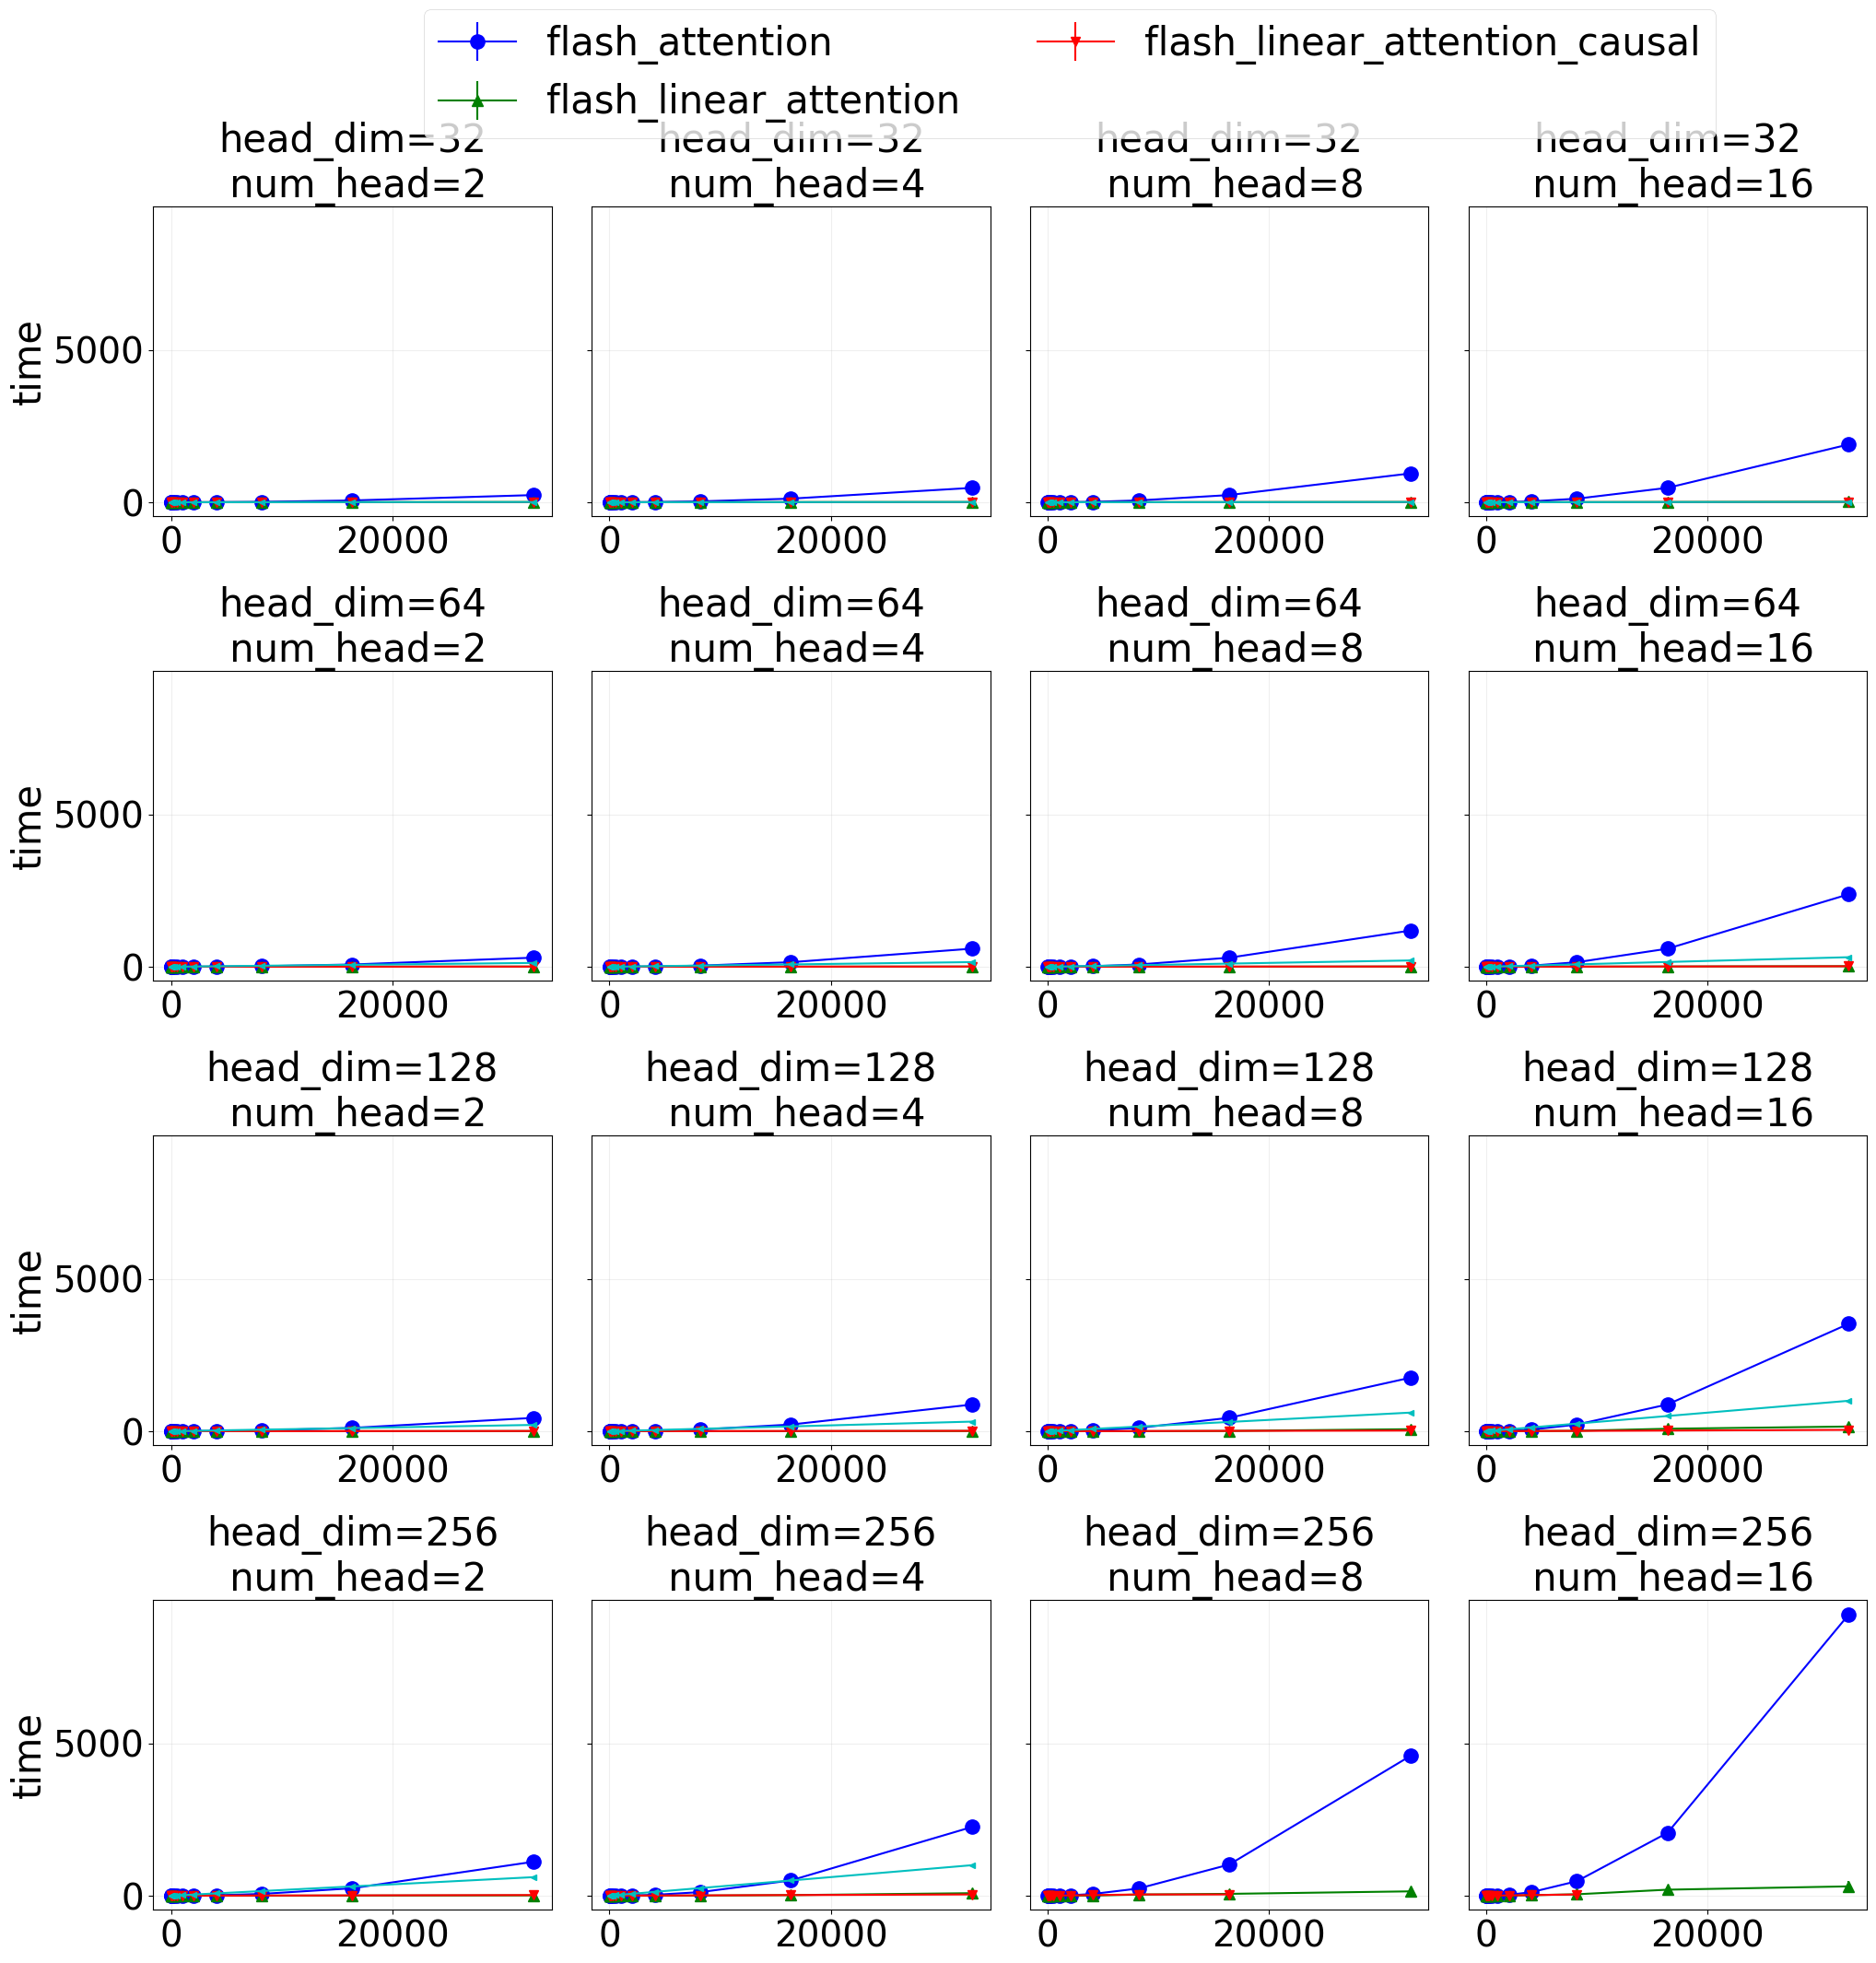

In [17]:
plot('time')

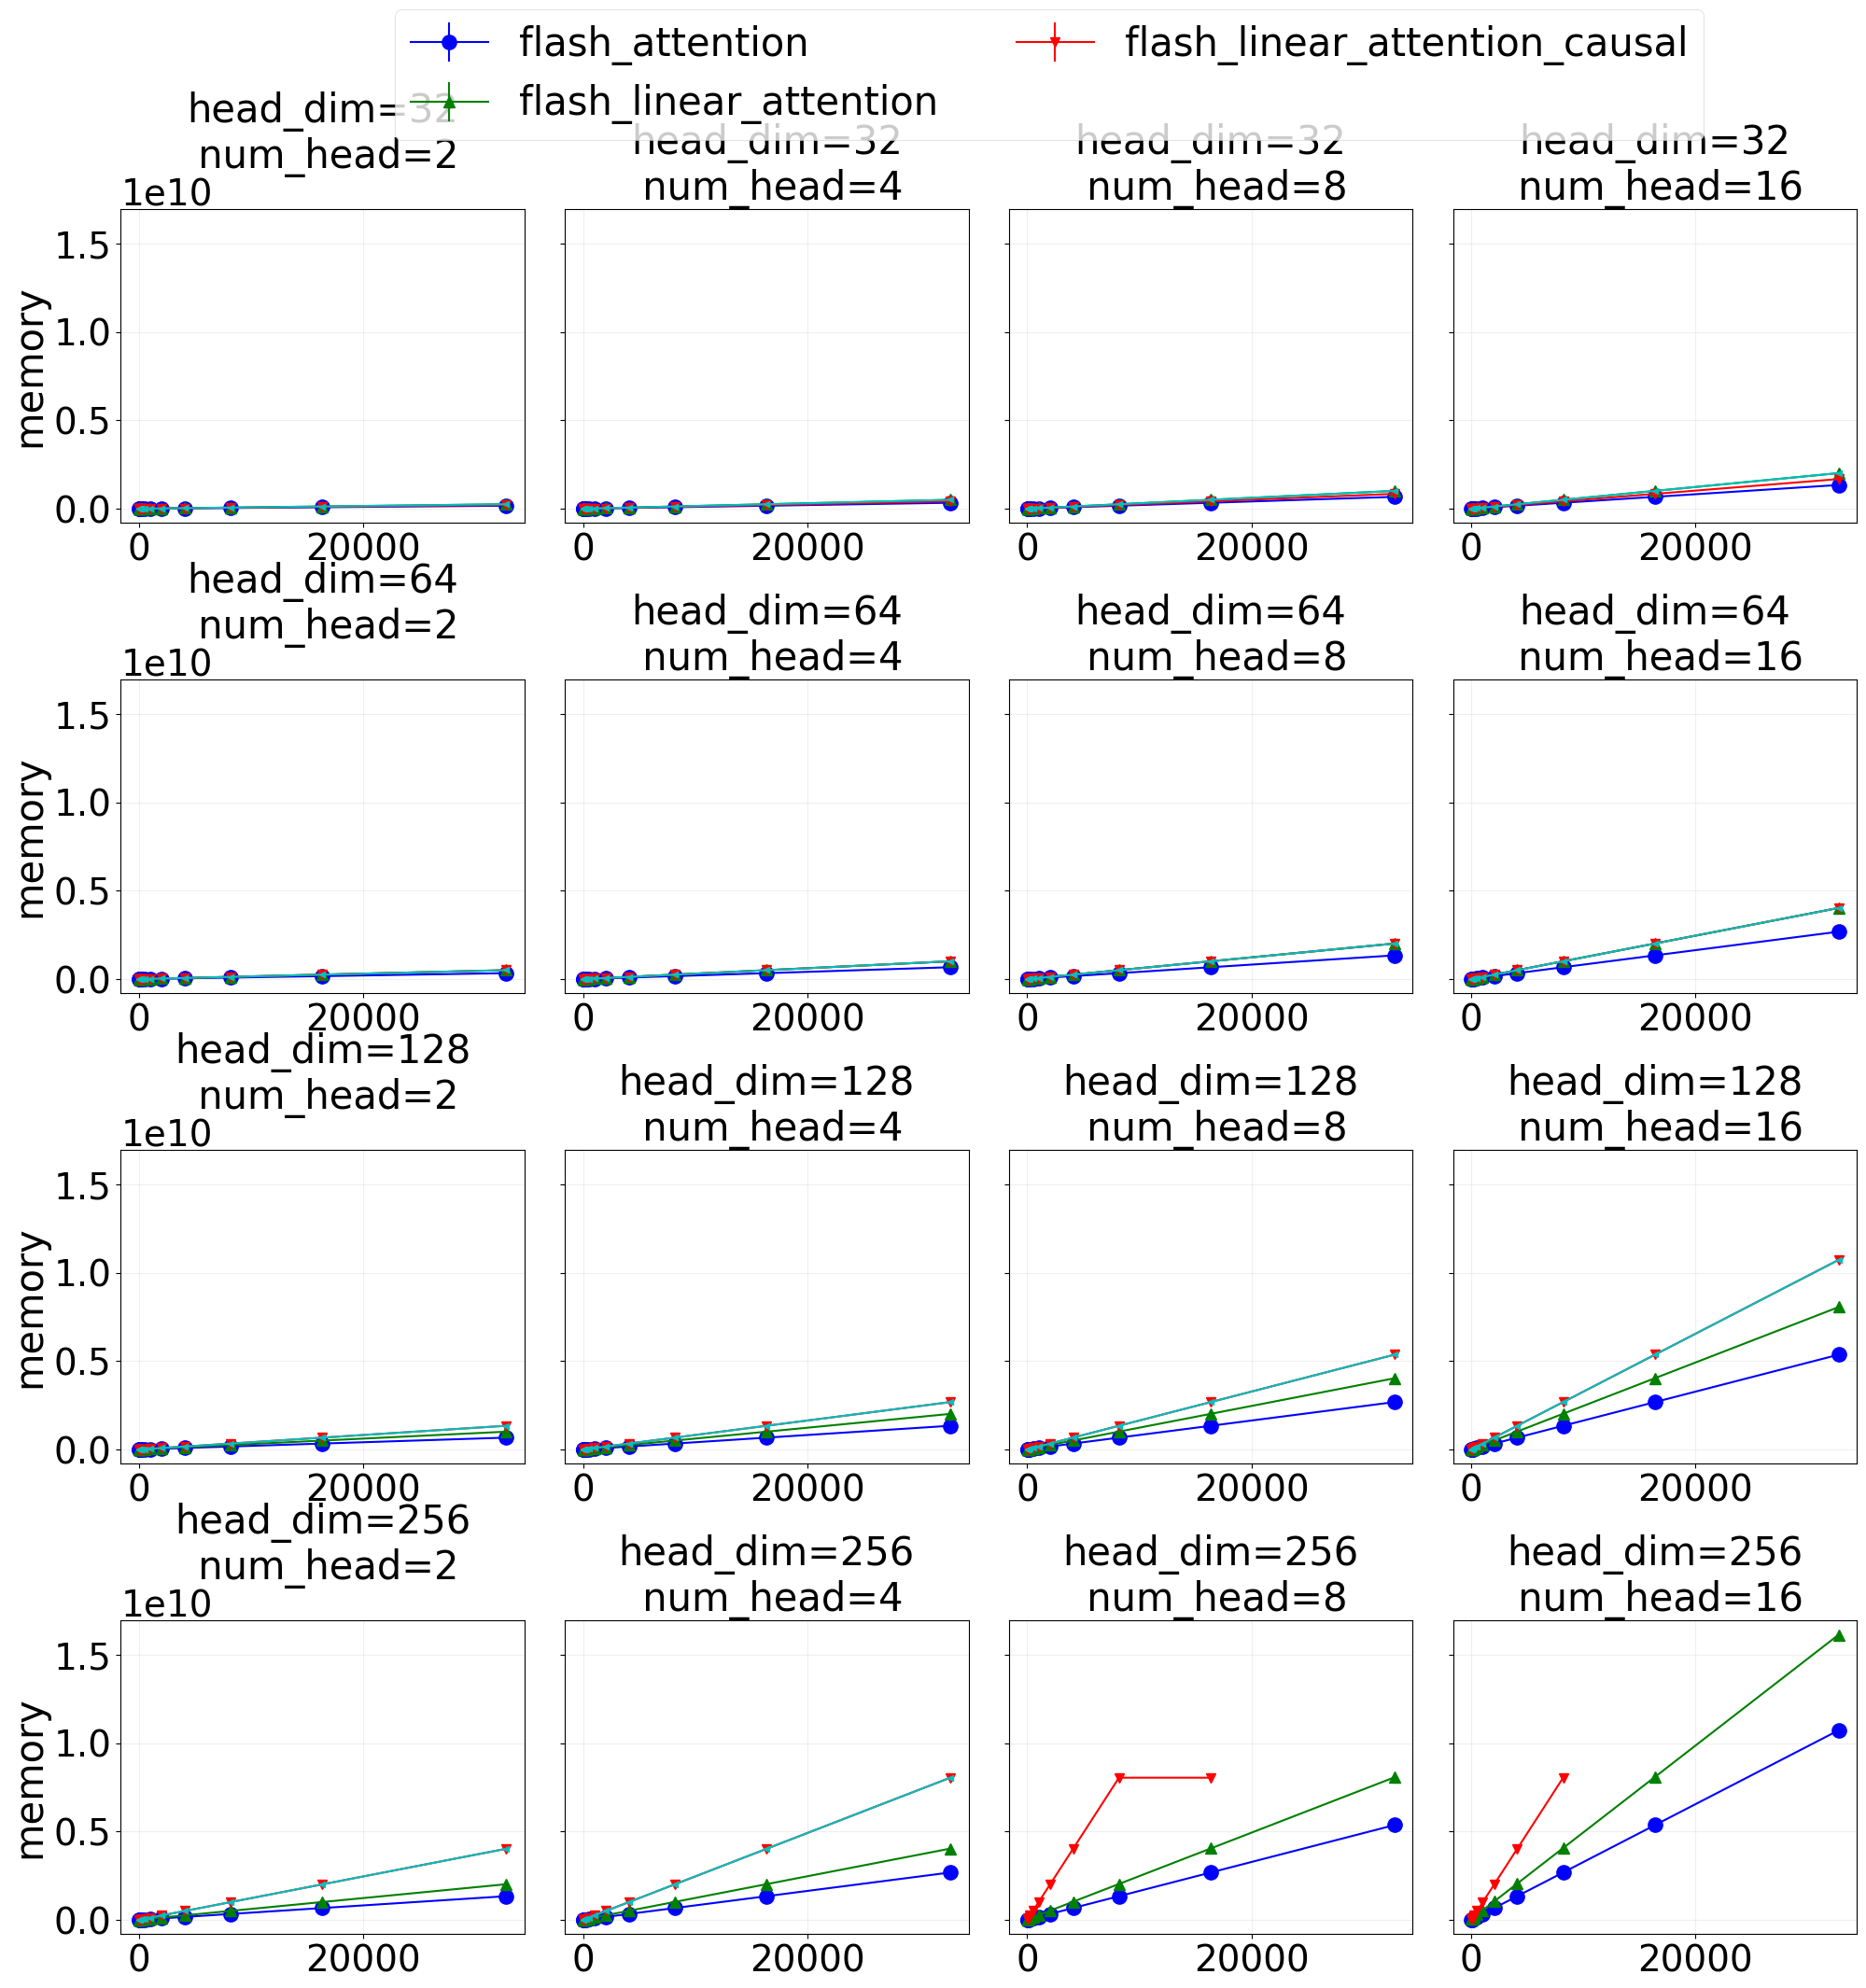

In [18]:
plot('memory')

In [52]:
def memory_estimate_plot(func_name):
    mode = 'memory'
    fig, axs = plt.subplots(
        len(head_dims), 
        len(num_heads), 
        figsize=(6*len(num_heads), 6*len(head_dims)),
        sharey=True,
    )
    fig.subplots_adjust(wspace=0.1, hspace = 0.5) 
    for f, label in enumerate(['actual', 'estimated']):
        for i in range(len(head_dims)):
            axs[i][0].set_ylabel(mode, fontsize=30)
            for j in range(len(num_heads)):
                key = '' if label == 'actual' else label + '_'
                df = results[f'{key}{mode}'][func_name][head_dims[i]][num_heads[j]]
                if df is None:
                    continue
                mean = df.mean()
                std = df.std()
                xticks = [int(x) for x in mean.index]
                axs[i][j].errorbar(
                    xticks, 
                    mean, 
                    yerr = std, 
                    label = label, 
                    color = color_list[f], 
                    marker = marker_list[f],
                    markersize = marker_sizes[f],
                )
                axs[i][j].grid(True, which="major", ls="-", alpha=0.2)
                # set title for each subplot
                axs[i][j].set_title(f"head_dim={head_dims[i]}\n num_head={num_heads[j]}", fontsize = 30)
             
    axs[-1][-1].legend(loc='upper center', bbox_to_anchor= (-1, 6.2), ncol=3,fontsize=30)
    plt.show()

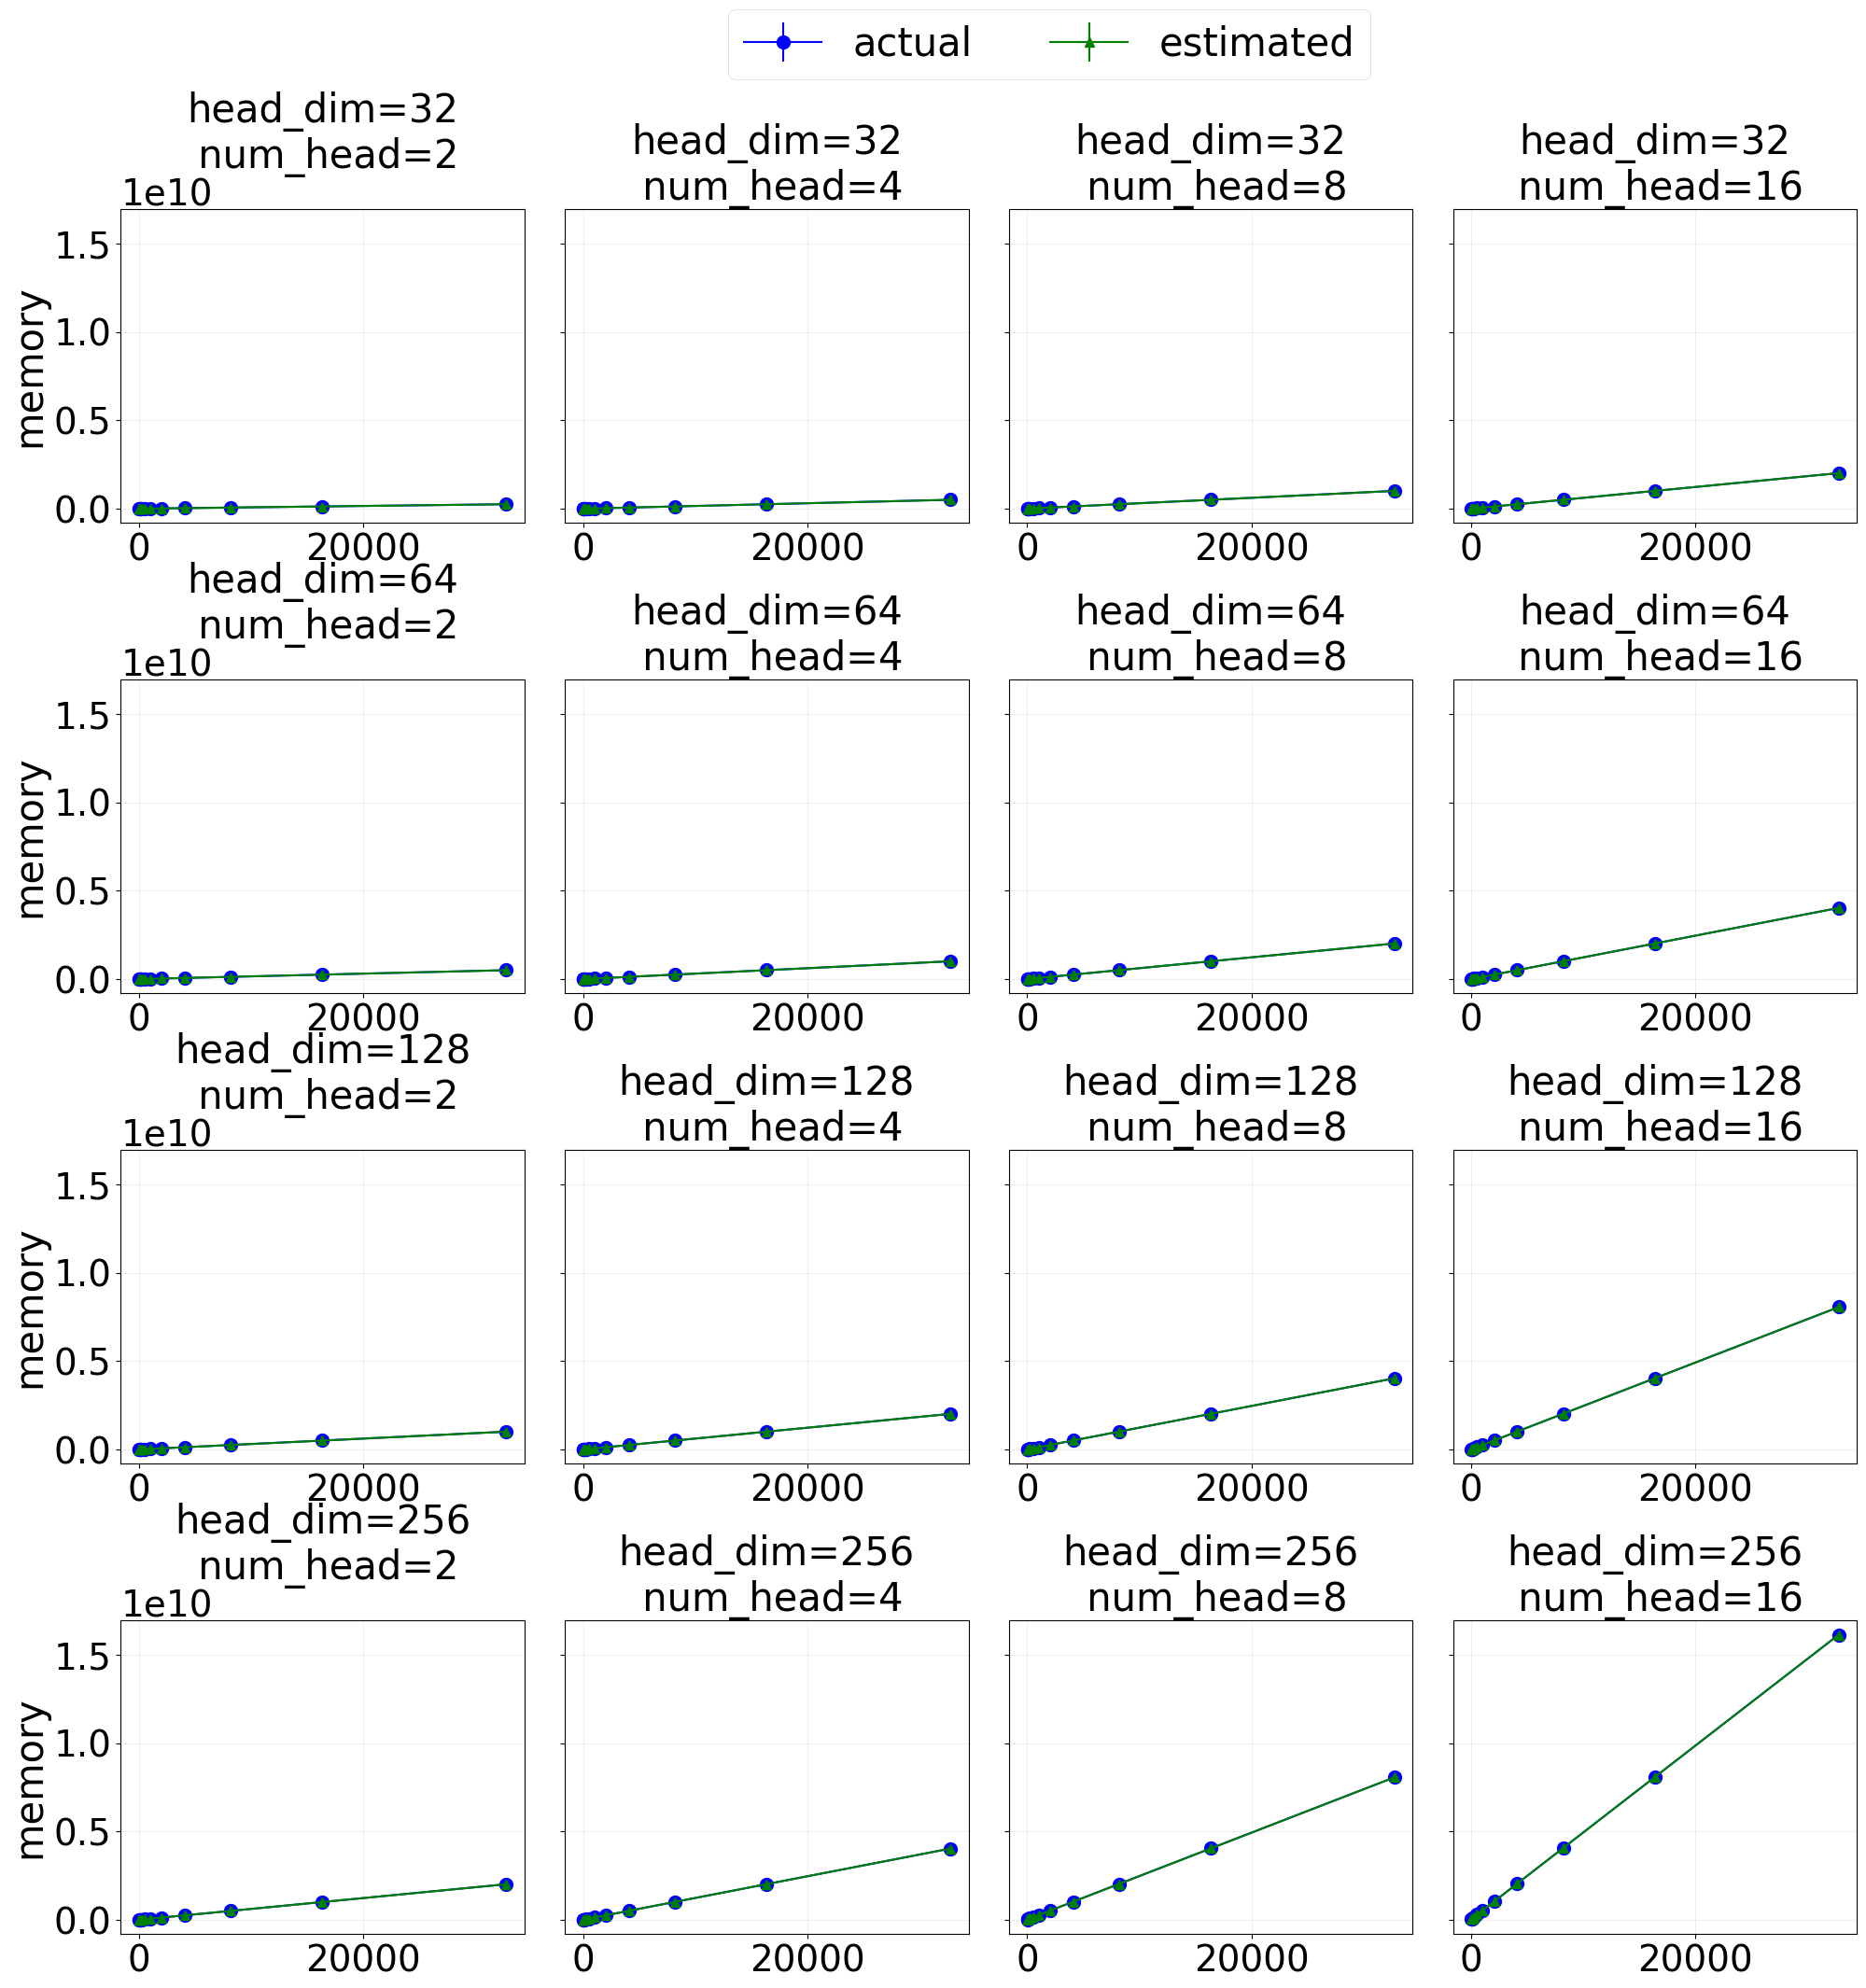

In [53]:
memory_estimate_plot('linear_attn')

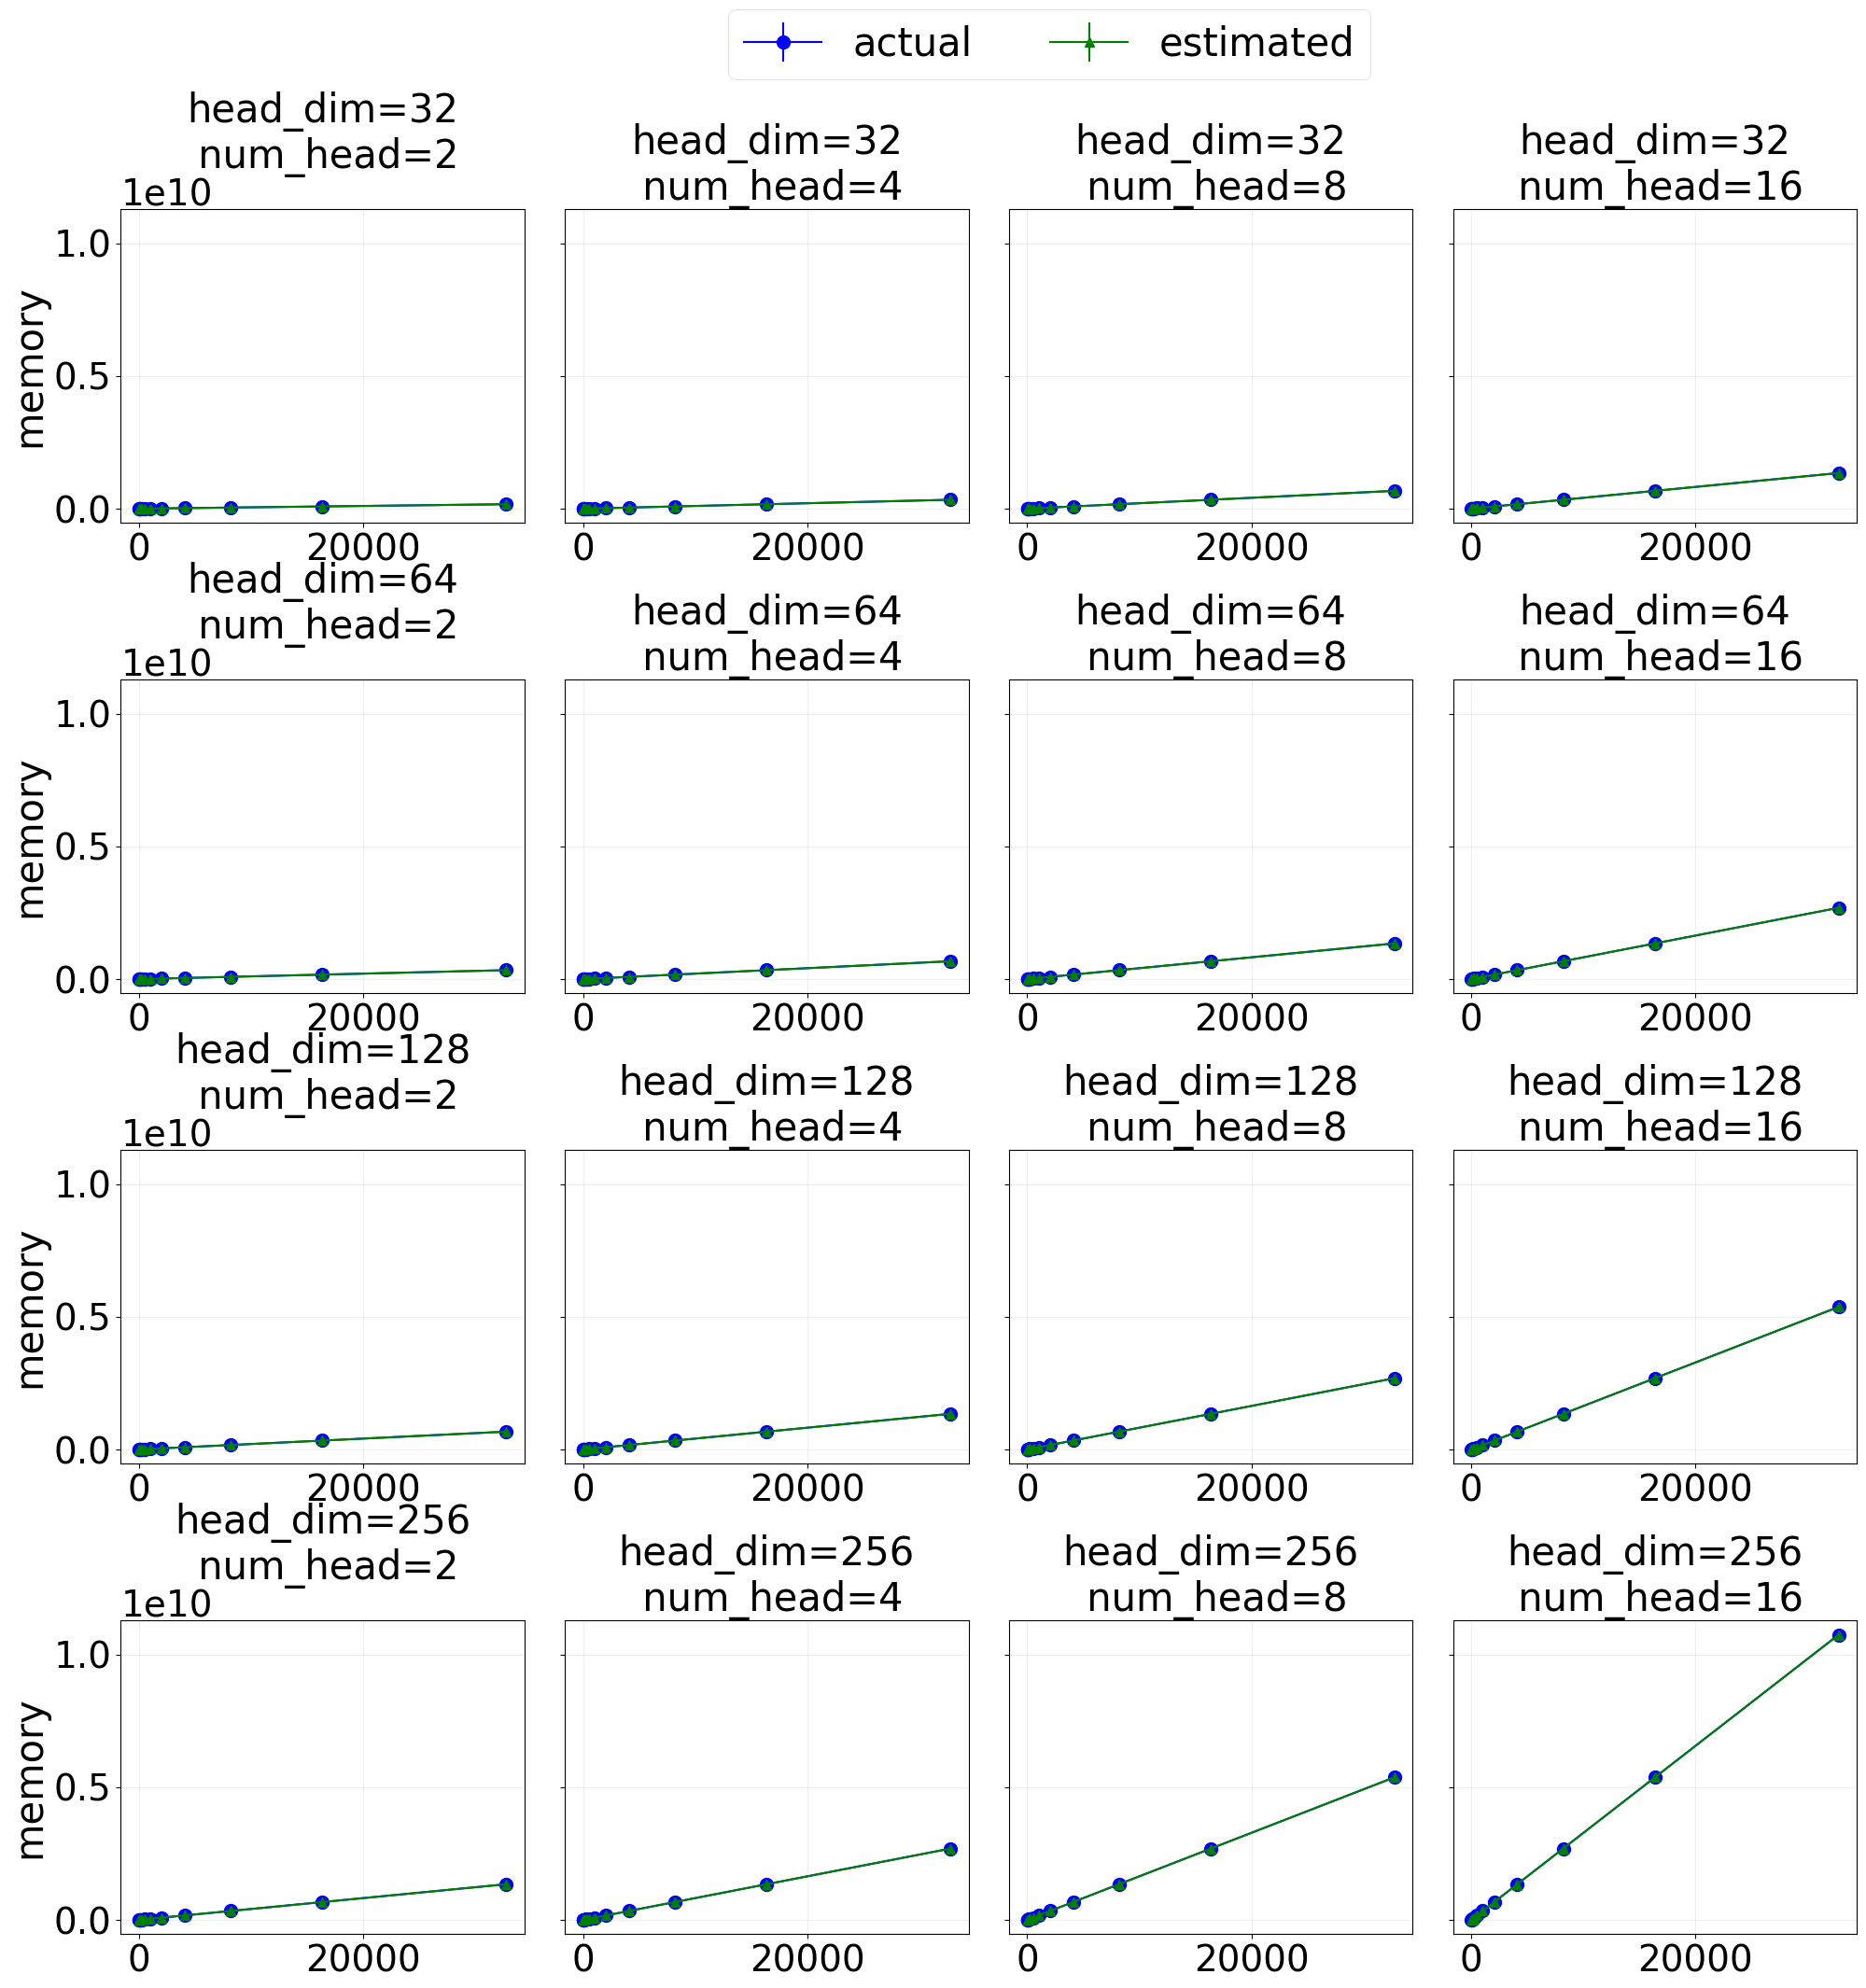

In [23]:
memory_estimate_plot('fa2')

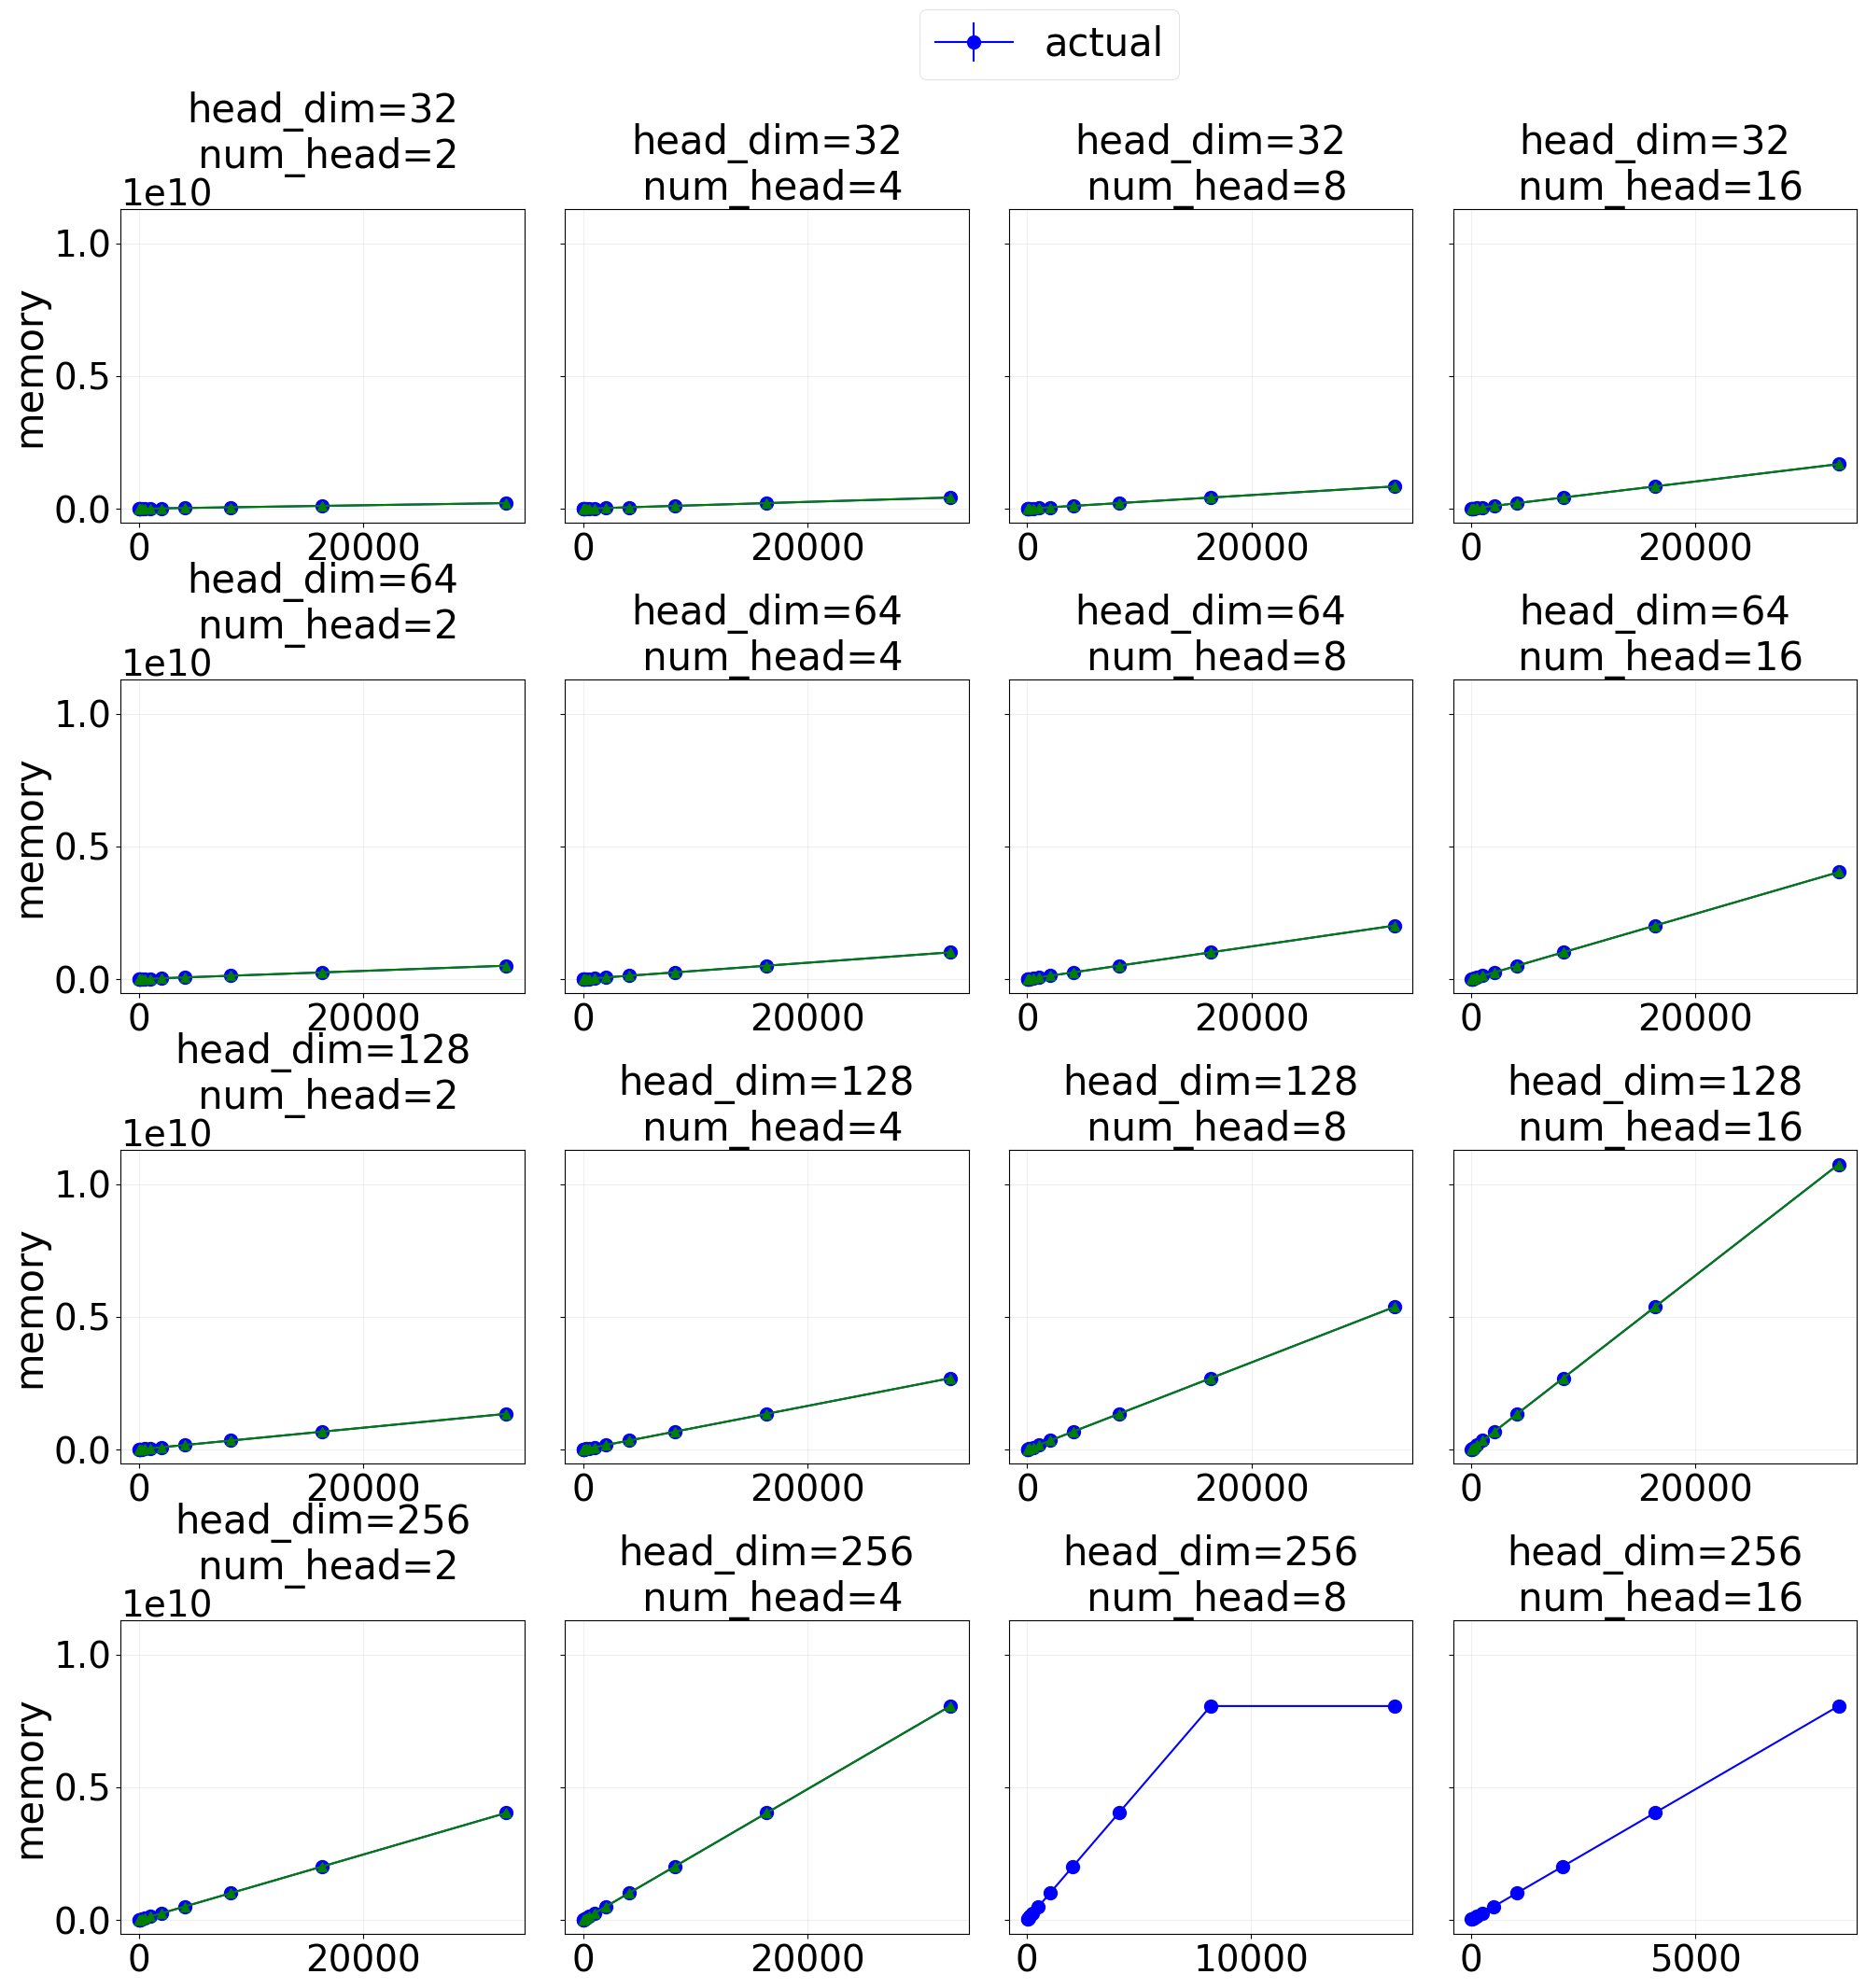

In [24]:
memory_estimate_plot('fla')

In [4]:
error_times = 5
assert error_times == 0

AssertionError: 